In [0]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Math, HTML, Markdown
from functools import partial

sns.set()

In [0]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Example 1: Calculating a posterior with no prior

AKA the classic coin flip example with a biased coin

Steps:


1.   Create 1000  Bernoulli trials
2.   Observe some proportion of the trials. This is the evidence
3.   Use the conjugate prior (beta distribution) to calculate our posterior beliefs in the bias of the coin (remember, Bayesians represent beliefs as probability distributions)


In [0]:
bias = 0.3

# Create a list of the number of coin tosses ("Bernoulli trials")
number_of_trials = [2, 5, 8, 10, 15, 20, 50, 1000]

# Conduct 500 coin tosses and output into a list of 0s and 1s
# where 0 represents a tail and 1 represents a head
data = stats.bernoulli.rvs(bias, size=number_of_trials[-1])

In [4]:
pd.Series(data).value_counts()

0    706
1    294
dtype: int64

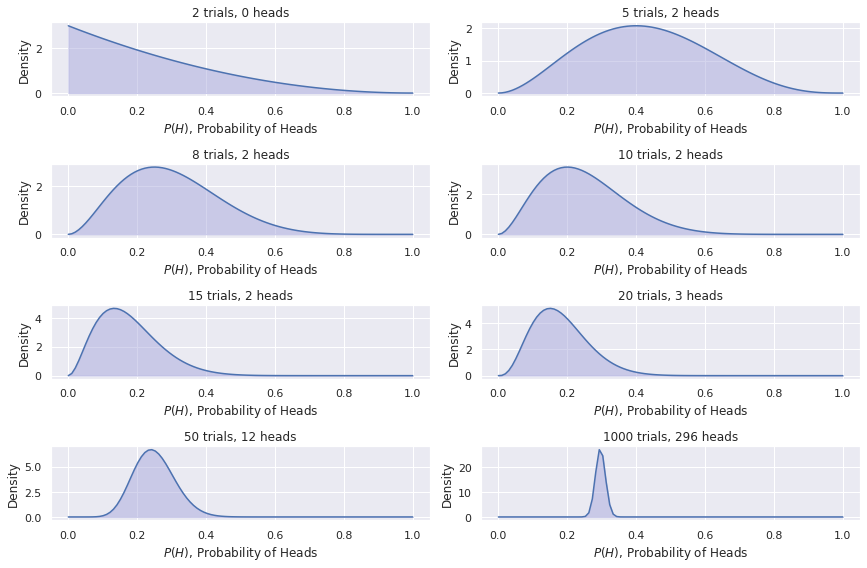

In [0]:
# Discretise the x-axis into 100 separate plotting points
x = np.linspace(0, 1, 100)

# Loops over the number_of_trials list to continually add
# more coin toss data. For each new set of data, we update
# our (current) prior belief to be a new posterior. This is
# carried out using what is known as the Beta-Binomial model
# (Beta distribution is the conjugate prior of the binomial distro)
for i, N in enumerate(number_of_trials):
    # Accumulate the total number of heads for this 
    # particular Bayesian update
    heads = data[:N].sum()

    ax = plt.subplot(len(number_of_trials) / 2, 2, i + 1)
    ax.set_title("%s trials, %s heads" % (N, heads))
    plt.xlabel("$P(H)$, Probability of Heads")
    plt.ylabel("Density")
            
    # Create and plot a  Beta distribution to represent the 
    # posterior belief in fairness of the coin.
    y = stats.beta.pdf(x, 1 + heads, 1 + N - heads)

    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#aaaadd", alpha=0.5)


# Expand plot to cover full width/height and show it
plt.tight_layout()

In this example, since we introduce no prior beliefs about the fairness of the coin, the frequentist and bayesian calculations are the same. However, we should briefly discuss the interpretation of the results.

The frequentist approach is to take the point of highest probability density (corresponding to the maximum likelihood estimate) and then constucting a confidence interval around the sample estimate. We must represent our estimated true value as a point estimate, and say that we have 95% confidence that the true value is within a given interval.

The Bayesian result states that we believe the true value could take on any non-zero probability within our range of beliefs (the beta distribution above), and the PDF at a given point corresponds to the strength of our belief that it could be the true value. We still take the maximum of the PDF, known as the maximum a prioiri estimate (MAP) as opposed to the MLE (though since we have no prior, these numbers are the same)


Example 2: Same as the first example, except via simulation instead of calculating the result analytically!

In [0]:
thetas = np.linspace(0, 1, num=1000)

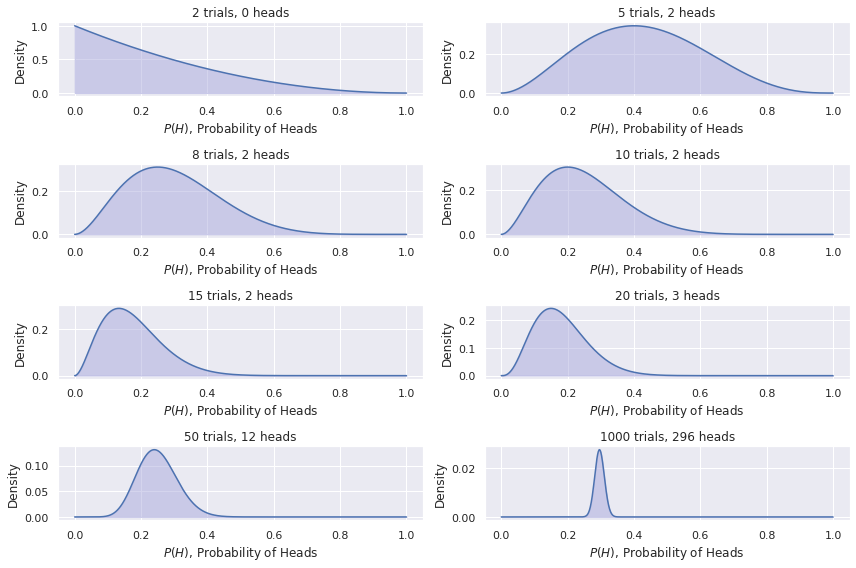

In [0]:

# We perform the same process as last time, except we do it via computationally instead of
# with the conjugate distribution. This would be considered when we had a complex
# distribution, or when our prior wasn't convenient as a conjugate
# We calculate the probability mass function of the binomial distribution at 
# each possible theta, given the observed number of heads. That likelihood
# becomes our posterior (absent of a prior, so posterior and likelihood are the same)
for i, N in enumerate(number_of_trials):
    heads = data[:N].sum()

    ax = plt.subplot(len(number_of_trials) / 2, 2, i + 1)
    ax.set_title("%s trials, %s heads" % (N, heads))
    plt.xlabel("$P(H)$, Probability of Heads")
    plt.ylabel("Density")
            
    # Calculate the binomial probability mass function for each possible
    # theta under consideration for our given experiment
    f = partial(stats.binom.pmf, heads, N)
    y = np.apply_along_axis(f, 0, thetas)

    plt.plot(thetas, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(thetas, 0, y, color="#aaaadd", alpha=0.5)

# Expand plot to cover full width/height and show it
plt.tight_layout()

Now, what if we add a prior? Recall that we can update our prior using Bayes theorem and our likelihood estimates according to 

In [0]:
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))
display(Math(r'P(\theta|X) = \frac{\mathcal{L}(X|\theta)P(\theta)}{\int\limits_0^1 \mathcal{L}(X|\theta)P(\theta)d\theta}'))

<IPython.core.display.Math object>

We will use a beta distribution as our prior. We know that most coins are fair, so we will center our estimate around 0.5. We also know that we are dealing with a shady individual, and so we won't choose a prior which is too narrow - this will make it difficult to update our hypothesis about the fairness of the coin as we gather more data.

We can think of using a wide distribution as having an open mind. The width of our prior distribution can also be seen as having a regularizing effect - the narrower our prior (the more convicion we have in our belief), the more evidence is needed to change our mind. That is, a narrower prior provides a stronger regularizing force. On the flipside, a wide prior will cause us to fit our posterior estimate much more closely to the data.

In [0]:
f = partial(stats.binom.pmf, data[:10].sum(), 10)
theta_likelihood = np.apply_along_axis(f, 0, thetas)

# Calculates P(theta|X) for a beta distribution prior of what the  
def calculate_posterior(a, b):
  # Probability density function for all thetas under consideration. This is our prior
  # for what we believe the coins bias could be
  p_theta = stats.beta.pdf(thetas, a,b)
  # Normalize p_theta so we're dealing with probabilities
  p_theta = (p_theta / p_theta.sum())
  # Probability of seeing the data is our confidence in the theta from our prior
  # multiplied by the likelihood that each theta could have generated the data,
  # integrated over all possible thetas under consideration. This is the 
  # demoninator of the equation above
  p_data = (theta_likelihood * p_theta).sum()

  # our updated posterior is the likelihood that the data was generated by a 
  # given theta, times our prior belief in the chance that that theta was used,
  # normalized by the sum of the possibilities that we've considered 
  p_theta_given_data = (theta_likelihood * p_theta) / p_data
  df_posterior = pd.DataFrame(index=thetas).assign(likelihood=theta_likelihood/theta_likelihood.sum(),
                                                 prior=p_theta, posterior=p_theta_given_data)
  return df_posterior


Observed 0 heads


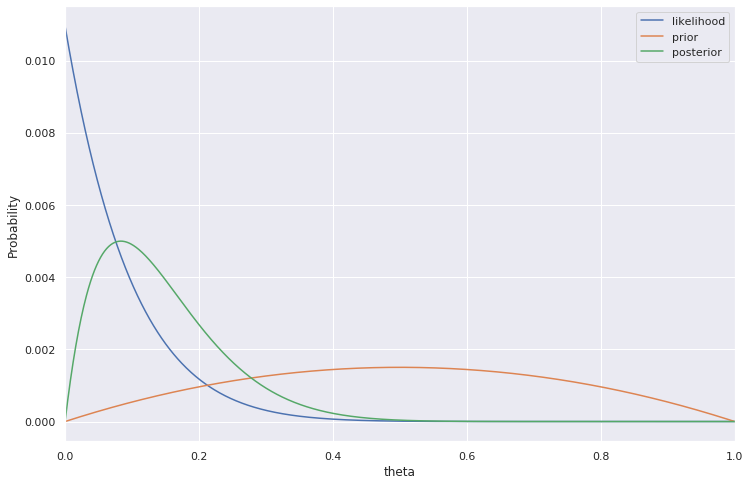

In [11]:
df_posterior = calculate_posterior(2, 2)
print(f'Observed {data[:10].sum()} heads')
df_posterior.plot()
plt.ylabel('Probability')
plt.xlabel('theta');

Let's look at the impact of a strong prior on our posterior. We start with the widest prior -- a uniform distrubution, and find that our posterior distribution is exactly equal to our likelihood. As we add more conviction that the coin is fair (narrow our prior distribution around 0.5) we see a greater regularizing effect and the resultant posterior does not move as much towards the sample likelihood  

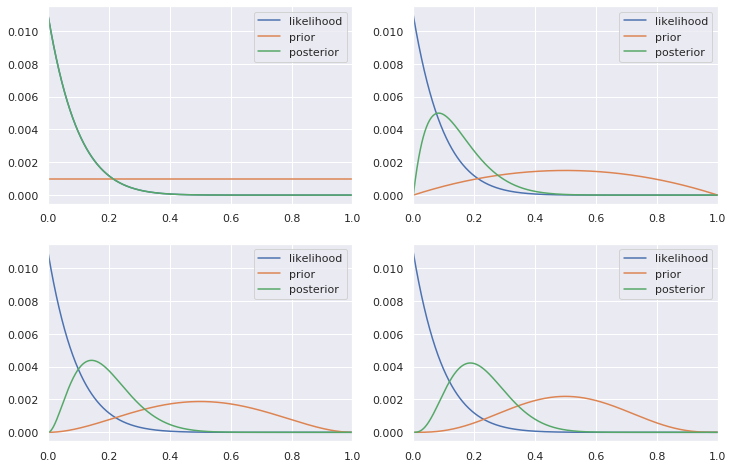

In [12]:
for i in range(1,5):
  ax = plt.subplot(2,2,i)
  df_posterior = calculate_posterior(i, i)
  #df_posterior = pd.DataFrame(index=thetas).assign(prior=p_theta, posterior=p_theta_given_data)
  df_posterior.plot(ax=ax)